In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from scipy.spatial import distance
from keras.applications.vgg19 import VGG19,preprocess_input
from keras import Sequential
from keras.models import load_model
from keras.layers import Flatten,Dense
from keras.preprocessing.image import ImageDataGenerator

In [71]:
!unzip -uq "/content/drive/MyDrive/dataset/archive (1).zip"

In [72]:
train_dir ="/content/Face Mask Dataset/Train"
test_dir ="/content/Face Mask Dataset/Test"
val_dir ="/content/Face Mask Dataset/Validation"

Data Augmentation

In [73]:
train_datagen = ImageDataGenerator(
               rescale =1.0/255,
               horizontal_flip=True,
               zoom_range=0.2,
               shear_range=0.2,
               rotation_range= 2,
               width_shift_range= 0.3
)

val_datagen =ImageDataGenerator(rescale =1.0/255)
test_datagen =ImageDataGenerator(rescale =1.0/255)

In [74]:
train_data = train_datagen.flow_from_directory(train_dir,target_size=(128,128))
test_data = test_datagen.flow_from_directory(test_dir,target_size=(128,128))
val_data = val_datagen.flow_from_directory(val_dir,target_size=(128,128))

Found 10800 images belonging to 3 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


VGG19 transfer learning model

In [75]:
vgg19 =VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
  layer.trainable =False

model =Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20040770 (76.45 MB)
Trainable params: 16386 (64.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [76]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics="accuracy")

In [ ]:
hist = model.fit(train_data,epochs=20,validation_data=val_data,steps_per_epoch=len(train_data)//32,validation_steps=len(val_data)//32)

In [ ]:
model.save("/content/drive/MyDrive/Saved models/masknet.h5")

In [78]:
model =load_model('/content/drive/MyDrive/Saved models/masknet.h5')

In [79]:
test= model.evaluate(test_data)

31/31 [==============================] - 3s 76ms/step - loss: 0.0338 - accuracy: 0.9899


In [80]:
print('Test accuracy %1.2f%%'%(test[1]*100))

Test accuracy 98.99%


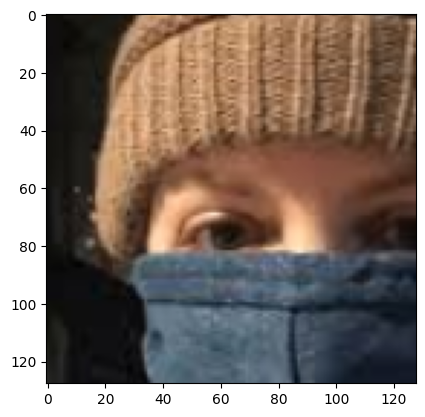

In [95]:
img =cv2.imread('/content/Face Mask Dataset/Test/WithMask/1439.png')
img =cv2.resize(img,(128,128))
img =cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()
img =np.resize(img,[1,128,128,3])
img = img/255.0

In [96]:
pred = model.predict(img)
pred =np.reshape(pred,-1)

if pred[0]>0.5:
  print('Wearing mask')
elif pred[1]>0.5:
  print('Not wearing mask')
else:
  print('Not confirm')

1/1 [==============================] - 0s 18ms/step
Wearing mask


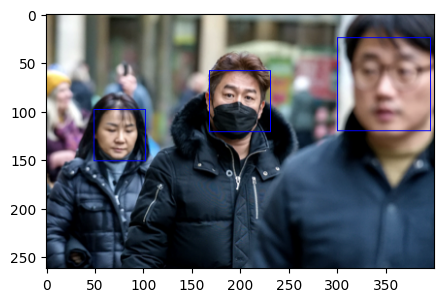

In [92]:
face_model =cv2.CascadeClassifier("/content/drive/MyDrive/haarcascade_frontalface_default.xml")
img =cv2.imread("/content/maksssksksss244.png")
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces =face_model.detectMultiScale(img,scaleFactor=1.2,minNeighbors=4, minSize=(40, 40),
        flags = cv2.CASCADE_SCALE_IMAGE)
out_img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
  cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(5,5))
plt.imshow(out_img)

In [93]:
mask_label ={0:'MASK',1:'NO MASK'}
dist_label ={0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE =130

1/1 [==============================] - 0s 28ms/step


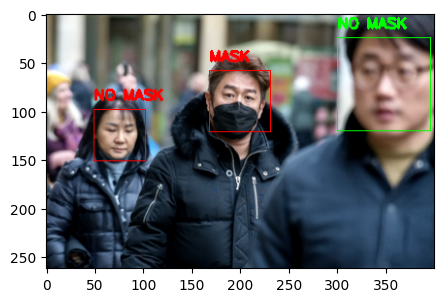

In [94]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(5,5))
    plt.imshow(new_img)

else:
    print("No. of faces detected is less than 2")